In [1]:
from __future__ import print_function, division

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Activation

from keras.optimizers import SGD

from keras import regularizers
from keras import initializers

import pandas as pd
from osgeo import gdal, gdal_array
import numpy as np

import os
from os import path

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

/home/monster/anaconda3/envs/geo_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/monster/anaconda3/envs/geo_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/monster/anaconda3/envs/geo_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/monster/anaconda3/envs/geo_py37

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [100, 100]

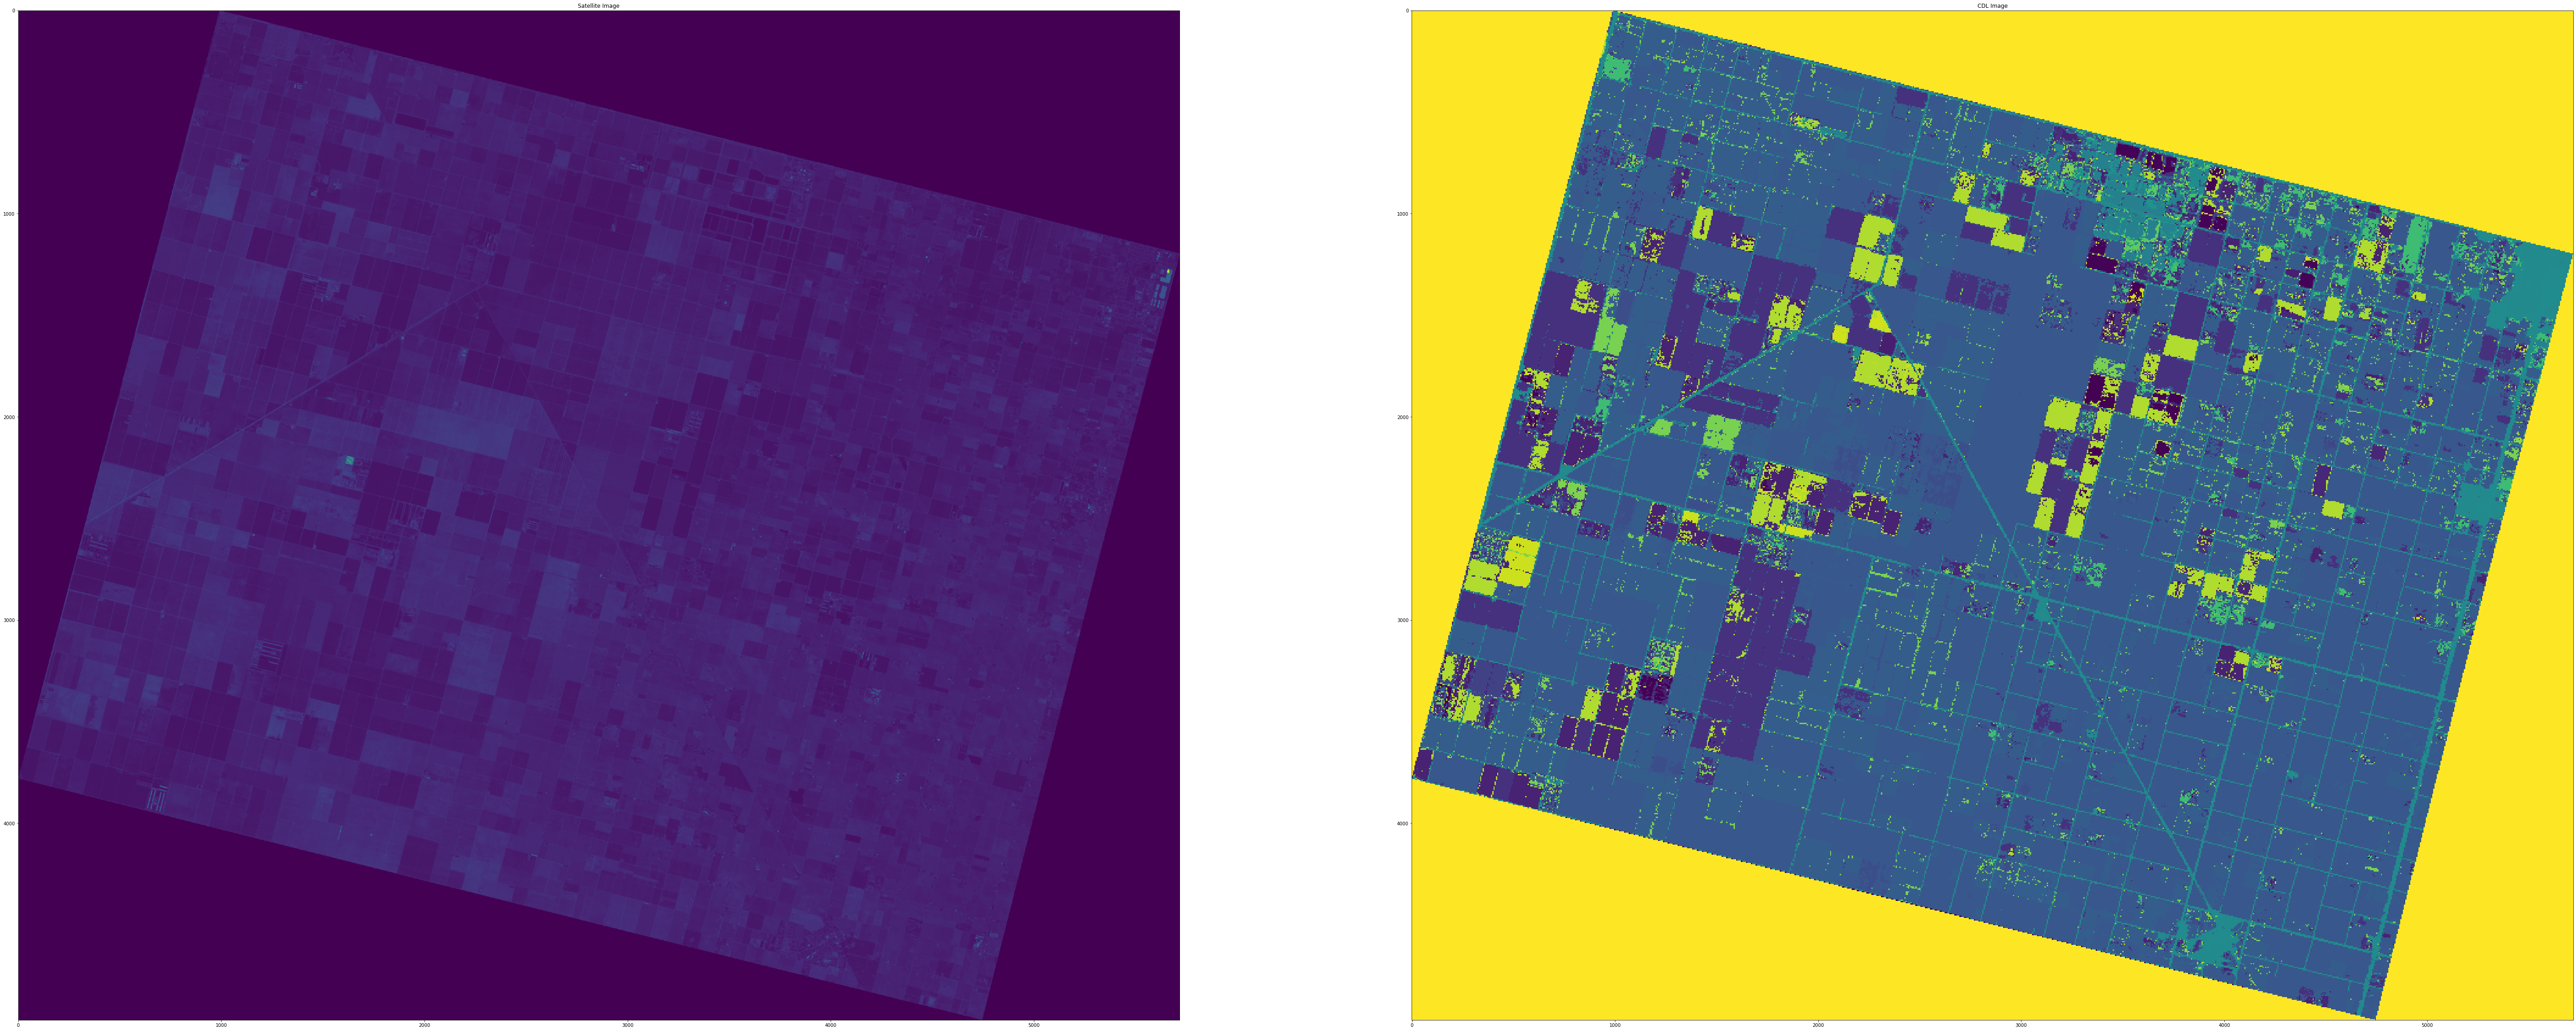

In [4]:
# Read in our image and ROI image
img_ds = gdal.Open('../Dataset/20170306.tiff', gdal.GA_ReadOnly)
roi_ds = gdal.Open('../Dataset/cdl2017.tiff', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 1])#, cmap=plt.cm.Spectral)
plt.title('Satellite Image')

plt.subplot(122)
plt.imshow(roi)#, cmap=plt.cm.Spectral)
plt.title('CDL Image')

plt.show()
    

In [5]:
#band and size info
img.shape,roi.shape

((4969, 5718, 5), (4969, 5718))

In [6]:
# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 6048 pixels
Class 1 contains 51120 pixels
Class 2 contains 70704 pixels
Class 4 contains 3492 pixels
Class 21 contains 47700 pixels
Class 23 contains 864 pixels
Class 24 contains 494748 pixels
Class 28 contains 73512 pixels
Class 33 contains 6120 pixels
Class 36 contains 1543068 pixels
Class 37 contains 23724 pixels
Class 42 contains 936 pixels
Class 48 contains 612 pixels
Class 49 contains 37476 pixels
Class 54 contains 15696 pixels
Class 57 contains 144 pixels
Class 59 contains 2124 pixels
Class 61 contains 379464 pixels
Class 66 contains 13464 pixels
Class 67 contains 8208 pixels
Class 69 contains 8311968 pixels
Class 71 contains 4644 pixels
Class 72 contains 144 pixels
Class 75 contains 4729104 pixels
Class 76 contains 340560 pixels
Class 77 contains 1620 pixels
Class 111 contains 148788 pixels
Class 121 contains 766044 pixels
Class 122 contains 331164 pixels
Class 123 contains 138420 pixels
Class 124 contains 31998 pixels
Class 131 contains 37512 pixels
Class 152 

In [7]:
top_classes = [69,75,36,121,225]

In [8]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#X = img_b1[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

#print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
#clear = X[:, 7] <= 1

#X = X[clear, :7]  # we can ditch the Fmask band now
#y = y[clear]

#print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 28406694 samples
The training data include 55 classes: [  1   2   4  21  23  24  28  33  36  37  42  48  49  54  57  59  61  66
  67  69  71  72  75  76  77 111 121 122 123 124 131 152 176 190 195 204
 205 206 208 209 212 213 216 217 218 220 224 225 226 227 236 237 238 242
 255]
Our y array is sized: (28406694,)
After masking, our y array is sized: (28406694,)


In [12]:
final = pd.read_csv("../Dataset/final.csv")

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final.iloc[:,:-1],final.iloc[:,-1], test_size=0.33, random_state=42)

In [14]:
X_train.shape,y_train.shape

((335000, 50), (335000,))

In [15]:
X_test.shape,y_test.shape

((165000, 50), (165000,))

In [16]:
final.columns = ['col_'+str(i) for i in range(51)]

In [17]:
final.head()

col_0   col_1   col_2   col_3   col_4   col_5    col_6    col_7   col_8  \
0  4077.0  3801.0  3588.0  3341.0  3509.0  9578.0  10052.0  10280.0  8968.0   
1  3400.0  3065.0  1710.0  3169.0  7538.0  7435.0   7382.0   7149.0  6712.0   
2  4518.0  3882.0  3839.0  3623.0  3788.0  6678.0   5938.0   6144.0  5540.0   
3  4078.0  3398.0  3342.0  2988.0  3025.0  5294.0   4518.0   3827.0  4085.0   
4  4403.0  3869.0  3487.0  3553.0  4081.0  6378.0   5924.0   6098.0  5600.0   

    col_9  ...  col_41  col_42  col_43   col_44  col_45  col_46  col_47  \
0  8832.0  ...  4815.0  2918.0  4605.0  12363.0  5228.0  4855.0  5013.0   
1  6667.0  ...  4802.0  2935.0  4860.0  11249.0  4058.0  3586.0  1835.0   
2  5463.0  ...  9226.0  8795.0  8145.0   8119.0  4128.0  3423.0  1559.0   
3  4035.0  ...  5541.0  3926.0  5093.0   8735.0  4712.0  4614.0  2746.0   
4  5386.0  ...  8122.0  7147.0  6846.0   7443.0  4279.0  3817.0  2050.0   

   col_48   col_49  col_50  
0  5556.0   6514.0     225  
1  4208.0   9019.0     225  
2  3836.0  12437.0     225  
3  4830.0   8588.0     225  
4  4205.0  12931.0     225  

[5 rows x 51 columns]

In [18]:
a = final.iloc[:,:50]
b = final['col_50']
y_final = final['col_50']
C = pd.concat([a,b],axis=1)

In [20]:
#NDVI

In [19]:
C.shape,a.shape,b.shape

((500000, 51), (500000, 50), (500000,))

In [20]:
C.head()

col_0   col_1   col_2   col_3   col_4   col_5    col_6    col_7   col_8  \
0  4077.0  3801.0  3588.0  3341.0  3509.0  9578.0  10052.0  10280.0  8968.0   
1  3400.0  3065.0  1710.0  3169.0  7538.0  7435.0   7382.0   7149.0  6712.0   
2  4518.0  3882.0  3839.0  3623.0  3788.0  6678.0   5938.0   6144.0  5540.0   
3  4078.0  3398.0  3342.0  2988.0  3025.0  5294.0   4518.0   3827.0  4085.0   
4  4403.0  3869.0  3487.0  3553.0  4081.0  6378.0   5924.0   6098.0  5600.0   

    col_9  ...  col_41  col_42  col_43   col_44  col_45  col_46  col_47  \
0  8832.0  ...  4815.0  2918.0  4605.0  12363.0  5228.0  4855.0  5013.0   
1  6667.0  ...  4802.0  2935.0  4860.0  11249.0  4058.0  3586.0  1835.0   
2  5463.0  ...  9226.0  8795.0  8145.0   8119.0  4128.0  3423.0  1559.0   
3  4035.0  ...  5541.0  3926.0  5093.0   8735.0  4712.0  4614.0  2746.0   
4  5386.0  ...  8122.0  7147.0  6846.0   7443.0  4279.0  3817.0  2050.0   

   col_48   col_49  col_50  
0  5556.0   6514.0     225  
1  4208.0   9019.0     225  
2  3836.0  12437.0     225  
3  4830.0   8588.0     225  
4  4205.0  12931.0     225  

[5 rows x 51 columns]

In [23]:
#NDVI

In [21]:
mul = [i*5 for i in list(range(11))]

In [22]:
mul

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [23]:
ndvi_df = pd.DataFrame(pd.Series(C.iloc[:,-1]))
i= 0
for m in mul[:-1]:
    print("printing for t_",i)
    print(a.iloc[:,0+m:5+m].head(5))
    temp = a.iloc[:,0+m:5+m]
    ndvi = (temp.loc[:,temp.columns[0]] - temp.loc[:,temp.columns[4]]) / (temp.loc[:,temp.columns[4]] + temp.loc[:,temp.columns[0]])
    Xt1 = pd.DataFrame(ndvi)
    Xt1.columns = ["t_"+str(i)]
    ndvi_df = pd.concat([Xt1,ndvi_df],axis=1)
    print(ndvi_df.shape)
    print("------------------------------")
    i+=1

printing for t_ 0
    col_0   col_1   col_2   col_3   col_4
0  4077.0  3801.0  3588.0  3341.0  3509.0
1  3400.0  3065.0  1710.0  3169.0  7538.0
2  4518.0  3882.0  3839.0  3623.0  3788.0
3  4078.0  3398.0  3342.0  2988.0  3025.0
4  4403.0  3869.0  3487.0  3553.0  4081.0
(500000, 2)
------------------------------
printing for t_ 1
    col_5    col_6    col_7   col_8   col_9
0  9578.0  10052.0  10280.0  8968.0  8832.0
1  7435.0   7382.0   7149.0  6712.0  6667.0
2  6678.0   5938.0   6144.0  5540.0  5463.0
3  5294.0   4518.0   3827.0  4085.0  4035.0
4  6378.0   5924.0   6098.0  5600.0  5386.0
(500000, 3)
------------------------------
printing for t_ 2
   col_10  col_11  col_12  col_13  col_14
0  7140.0  7413.0  7128.0  6342.0  6442.0
1  7746.0  7603.0  7823.0  6855.0  6792.0
2  9418.0  9600.0  9507.0  8277.0  8132.0
3  7444.0  7222.0  7237.0  6569.0  6669.0
4  4942.0  4164.0  2658.0  4614.0  9598.0
(500000, 4)
------------------------------
printing for t_ 3
   col_15  col_16  col_17  col_

In [24]:
ndvi_df.head()

t_9       t_8       t_7       t_6       t_5       t_4       t_3  \
0 -0.109521 -0.356485  0.058042 -0.070582 -0.288834 -0.404808 -0.203625   
1 -0.379368 -0.313445  0.033569  0.041928 -0.163879 -0.316862  0.088598   
2 -0.501600  0.076284  0.014442  0.016107  0.025147 -0.308444 -0.206523   
3 -0.291429 -0.172247  0.033504  0.035193 -0.334365 -0.282430  0.014830   
4 -0.502731  0.074254  0.000869  0.078289 -0.081007 -0.322278 -0.364617   

        t_2       t_1       t_0  col_50  
0  0.051392  0.040521  0.074875     225  
1  0.065621  0.054460 -0.378314     225  
2  0.073276  0.100074  0.087888     225  
3  0.054914  0.134956  0.148247     225  
4 -0.320220  0.084325  0.037954     225

In [25]:
ndvi_df.shape

(500000, 11)

In [26]:
ndvi_df.columns

Index(['t_9', 't_8', 't_7', 't_6', 't_5', 't_4', 't_3', 't_2', 't_1', 't_0',
       'col_50'],
      dtype='object')

In [27]:
c1 = pd.DataFrame(np.mean(ndvi_df.loc[ndvi_df['col_50']==69,['t_9', 't_8', 't_7', 't_6', 't_5', 't_4', 't_3', 't_2', 't_1', 't_0']],axis=0))
c2 = pd.DataFrame(np.mean(ndvi_df.loc[ndvi_df['col_50']==75,['t_9', 't_8', 't_7', 't_6', 't_5', 't_4', 't_3', 't_2', 't_1', 't_0']],axis=0))
c3 = pd.DataFrame(np.mean(ndvi_df.loc[ndvi_df['col_50']==121,['t_9', 't_8', 't_7', 't_6', 't_5', 't_4', 't_3', 't_2', 't_1', 't_0']],axis=0))
c4 = pd.DataFrame(np.mean(ndvi_df.loc[ndvi_df['col_50']==225,['t_9', 't_8', 't_7', 't_6', 't_5', 't_4', 't_3', 't_2', 't_1', 't_0']],axis=0))

t_9       t_8       t_7       t_6       t_5       t_4       t_3  \
0  -0.109521 -0.356485  0.058042 -0.070582 -0.288834 -0.404808 -0.203625   
1  -0.379368 -0.313445  0.033569  0.041928 -0.163879 -0.316862  0.088598   
2  -0.501600  0.076284  0.014442  0.016107  0.025147 -0.308444 -0.206523   
3  -0.291429 -0.172247  0.033504  0.035193 -0.334365 -0.282430  0.014830   
4  -0.502731  0.074254  0.000869  0.078289 -0.081007 -0.322278 -0.364617   
5  -0.475328 -0.390950  0.021936 -0.055216 -0.088260 -0.364768 -0.209918   
6  -0.463985 -0.309718 -0.221585  0.129805 -0.365327 -0.385581 -0.212710   
7  -0.515075  0.081634  0.022596  0.058698 -0.349147 -0.396981 -0.215890   
8  -0.488151 -0.248506  0.063029  0.082278 -0.060106 -0.257813  0.022493   
9  -0.528564 -0.248202  0.077995 -0.338342 -0.194299 -0.378926 -0.128919   
10 -0.506229  0.047766  0.062656  0.040848  0.105437 -0.334438 -0.109411   
11 -0.435894 -0.363303  0.059276  0.040696 -0.393284 -0.364958  0.024849   
12 -0.453710 -0.347671  0.102523 -0.063291 -0.043836 -0.369985 -0.096267   
13 -0.484759 -0.168325  0.016885  0.024388 -0.265161 -0.027301  0.127536   
14 -0.053978 -0.321917  0.097565 -0.081204 -0.173058 -0.232044 -0.156277   
15 -0.484487 -0.145819  0.022580 -0.003703 -0.258443 -0.354177 -0.011078   
16 -0.421947  0.080321 -0.244789  0.026023  0.013942 -0.377658 -0.239672   
17 -0.266894 -0.311264  0.080664 -0.041771  0.043126 -0.232177 -0.129660   
18 -0.473264 -0.354610  0.042410  0.088852 -0.049165 -0.172456 -0.207271   
19 -0.332422 -0.323416  0.167867  0.093955 -0.243462 -0.382743  0.108045   

         t_2       t_1       t_0  col_50   avg_ndvi  
0   0.051392  0.040521  0.074875     225  20.344634  
1   0.065621  0.054460 -0.378314     225  20.339301  
2   0.073276  0.100074  0.087888     225  20.397877  
3   0.054914  0.134956  0.148247     225  20.394652  
4  -0.320220  0.084325  0.037954     225  20.334985  
5   0.025701  0.046080  0.081493     225  20.326433  
6   0.007424  0.096143  0.047619     225  20.302008  
7  -0.262972  0.020937 -0.015187     225  20.311692  
8   0.116227  0.220838 -0.086682     225  20.396691  
9  -0.082449  0.034630 -0.228372     225  20.271323  
10  0.075178  0.143769  0.251955     225  20.434321  
11  0.067851  0.050223 -0.357293     225  20.302560  
12  0.042770  0.062233  0.123954     225  20.359702  
13 -0.267548  0.069154 -0.224096     225  20.345525  
14 -0.021616  0.065447  0.076360     225  20.381753  
15 -0.227451  0.092611  0.221363     225  20.350127  
16  0.074112  0.075188 -0.048320     225  20.357927  
17  0.082876  0.009069  0.067947     225  20.391083  
18  0.062567  0.128896 -0.334401     225  20.339233  
19  0.022551  0.040575  0.152032     225  20.391180

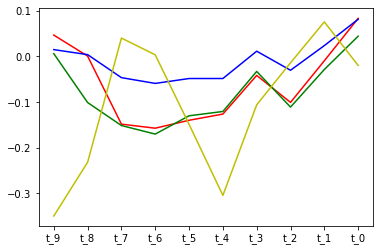

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(c1.index,c1.iloc[:,0],color='r')
plt.plot(c2.index,c2.iloc[:,0],color='g')
plt.plot(c3.index,c3.iloc[:,0],color='b')
plt.plot(c4.index,c4.iloc[:,0],color='y')

ndvi_df['avg_ndvi'] = np.mean(ndvi_df,axis=1)

pd.pivot_table(ndvi_df,index=["col_50"],values = ['avg_ndvi'] ,aggfunc=np.mean)

ndvi_df.head(20)